In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim

import time
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

device: cuda:0


In [4]:
class NN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction = 'mean')
        self.layers = layers

        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])


        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain = 1.0)
            nn.init.zeros_(self.linears[i].bias.data)



    def forward(self,x,y,t):
        a = torch.cat([x,y,t], dim = 1)

        for i in range(len(self.layers)-2):
            L = self.linears[i](a)
            a = self.activation(L)

        b = self.linears[-1](a)

        return b


In [5]:
layers = np.array([3,128,128,128,128,1])
net_phi = NN(layers).to(device)
net_mu = NN(layers).to(device)

In [6]:
# Define LHS

def lhs(n:int, d:int, low: np.ndarray, high: np.ndarray) -> np.ndarray:

    low = np.asarray(low).reshape(1,d)
    high = np.asarray(high).reshape(1,d)

    m = np.random.rand(n,d)

    a = np.linspace(0,1,n, endpoint = False).reshape(n,1)
    b = np.linspace(1/n,1,n).reshape(n,1)

    pts =  a + m*(b-a)

    for j in range(d):
        np.random.shuffle(pts[:,j])

    return low+(high-low)*pts


In [7]:
# Create Collocation Points

X = lhs(n = 10000, d=3, low=np.array([-1,-1,0]), high = np.array([1,1,0.5]))

x_f = (X[:,[0]])
x_f = torch.tensor(x_f, dtype = torch.float32, device = device, requires_grad=True)

y_f = (X[:,[1]])
y_f = torch.tensor(y_f, dtype = torch.float32, device = device, requires_grad=True)


t_f = (X[:,[2]])
t_f = torch.tensor(t_f, dtype = torch.float32, device = device, requires_grad=True)



In [8]:
def bc_loss():
    x_l = -torch.ones(200,1)
    x_l = torch.tensor(x_l, dtype = torch.float32, device = device, requires_grad=True)


    x_r = torch.ones(200,1)
    x_r = torch.tensor(x_r, dtype = torch.float32, device = device, requires_grad=True)

    y_l = -torch.ones(200,1)
    y_l = torch.tensor(y_l, dtype = torch.float32, device = device, requires_grad=True)


    y_r = torch.ones(200,1)
    y_r = torch.tensor(y_r, dtype = torch.float32, device = device, requires_grad=True)


    t = torch.rand(200,1)
    t = torch.tensor(t, dtype = torch.float32, device = device)

    x = torch.linspace(-1,1,200).view(-1,1)
    x = torch.tensor(x, dtype = torch.float32, device = device)

    y = torch.linspace(-1,1,200).view(-1,1)
    y = torch.tensor(y, dtype = torch.float32, device = device)


    phi_x_left = net_phi(x_l,y,t)
    phi_x_right = net_phi(x_r,y, t)

    phi_y_left = net_phi(x,y_l,t)
    phi_y_right = net_phi(x,y_r, t)

    phi_l_x_der = torch.autograd.grad(phi_x_left, x_l, torch.ones_like(phi_x_left), create_graph=True)[0]
    phi_r_x_der = torch.autograd.grad(phi_x_right, x_r, torch.ones_like(phi_x_right), create_graph=True)[0]

    phi_l_y_der = torch.autograd.grad(phi_y_left, y_l, torch.ones_like(phi_y_left), create_graph=True)[0]
    phi_r_y_der = torch.autograd.grad(phi_y_right, y_r, torch.ones_like(phi_y_right), create_graph=True)[0]

    res_bc_1 = phi_x_left - phi_x_right
    loss_bc_1 = torch.mean(res_bc_1 ** 2)

    res_bc_2 = phi_y_left - phi_y_right
    loss_bc_2 = torch.mean(res_bc_2 ** 2)

    res_bc_3 = phi_l_x_der - phi_r_x_der
    loss_bc_3 = torch.mean(res_bc_3 ** 2)

    res_bc_4 = phi_l_y_der - phi_r_y_der
    loss_bc_4 = torch.mean(res_bc_4 ** 2)


    loss_bc = loss_bc_1 + loss_bc_2 + loss_bc_3 + loss_bc_4


    return loss_bc

In [41]:


def ic_loss():

    C0  = 0.0      
    eps = 0.02
    


    X0 = lhs(n=3000, d=2, low=np.array([-1.0, -1.0]), high=np.array([1.0, 1.0]))

    x0 = torch.tensor(X0[:, [0]], dtype=torch.float32, device=device)
    y0 = torch.tensor(X0[:, [1]], dtype=torch.float32, device=device)
    t0 = torch.zeros(3000, 1, dtype=torch.float32, device=device)

    
    noise = torch.randn(3000, 1, dtype=torch.float32, device=device)
    phi0 = C0 + eps * noise
    phi0 = phi0 - phi0.mean() + C0  

    
    phi_pred0 = net_phi(x0, y0, t0)

    
    res_ic = phi_pred0 - phi0
    loss_ic = torch.mean(res_ic**2)
    return loss_ic



In [42]:
def pde_loss(x,y,t):
    gam = 0.5
    
    D = 1

    
    
    phi = net_phi(x,y,t)

    phi_t = torch.autograd.grad(phi, t, torch.ones_like(phi), create_graph=True)[0]
    phi_x = torch.autograd.grad(phi, x, torch.ones_like(phi), create_graph=True)[0]
    phi_x_x = torch.autograd.grad(phi_x, x, torch.ones_like(phi_x), create_graph=True)[0]
    phi_y = torch.autograd.grad(phi, y, torch.ones_like(phi), create_graph=True)[0]
    phi_y_y = torch.autograd.grad(phi_y, y, torch.ones_like(phi_y), create_graph=True)[0]


    mu = net_mu(x,y,t)
    mu_x = torch.autograd.grad(mu, x, torch.ones_like(mu), create_graph=True)[0]
    mu_x_x = torch.autograd.grad(mu_x, x, torch.ones_like(mu_x), create_graph=True)[0]
    mu_y = torch.autograd.grad(mu, y, torch.ones_like(mu), create_graph=True)[0]
    mu_y_y = torch.autograd.grad(mu_y, y, torch.ones_like(mu_y), create_graph=True)[0]




    res_mu = mu - (-gam *(phi_x_x + phi_y_y) + phi**3 - phi)
    loss_mu = torch.mean(res_mu**2)


    res_pde_1 = phi_t - D*(mu_x_x + mu_y_y)
    # res_pde_1 = phi_t - lam*(mu_x_x + mu_y_y)
    pde_loss_1 = torch.mean(res_pde_1**2)


    loss_pde = loss_mu + pde_loss_1


    return loss_pde

    

In [43]:
def add_losses():
    loss_bc = bc_loss()
    loss_ic = ic_loss()
    loss_pde = pde_loss(x_f, y_f, t_f)


    total_loss = 10*loss_bc + 1000*loss_ic + loss_pde


    return total_loss
    

In [44]:
optimizer_phi = torch.optim.Adam(net_phi.parameters(), lr = 0.001)
optimizer_mu = torch.optim.Adam(net_mu.parameters(), lr = 0.001)

In [45]:
torch.manual_seed(42)

In [46]:
if device.type == 'cuda':
    torch.cuda.reset_peak_memory_stats(device)

In [47]:
start_time = time.time()

num_epochs = 20000

total_loss_list = []

for epoch in range(num_epochs):
    optimizer_phi.zero_grad()
    optimizer_mu.zero_grad()
    

    total_loss = add_losses()

    total_loss.backward()
    

    optimizer_phi.step()
    optimizer_mu.step()
    

    
    total_loss_list.append(total_loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}:  total loss={total_loss.item():.3e}")

    
end_time = time.time()

print(f'Total Training Time: {(end_time - start_time): .4f}seconds')

/tmp/ipykernel_244775/583930700.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_l = torch.tensor(x_l, dtype = torch.float32, device = device, requires_grad=True)
/tmp/ipykernel_244775/583930700.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_r = torch.tensor(x_r, dtype = torch.float32, device = device, requires_grad=True)
/tmp/ipykernel_244775/583930700.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_l = torch.tensor(y_l, dtype = torch.float32, device = device, requires_grad=True)
/tmp/ipykernel_244775/583930700.py:14: 

Epoch 0:  total loss=3.935e-01
Epoch 500:  total loss=3.802e-01
Epoch 1000:  total loss=3.868e-01
Epoch 1500:  total loss=4.123e-01
Epoch 2000:  total loss=4.159e-01
Epoch 2500:  total loss=3.982e-01
Epoch 3000:  total loss=4.013e-01
Epoch 3500:  total loss=3.976e-01
Epoch 4000:  total loss=3.897e-01
Epoch 4500:  total loss=4.023e-01
Epoch 5000:  total loss=3.908e-01
Epoch 5500:  total loss=3.992e-01
Epoch 6000:  total loss=3.789e-01
Epoch 6500:  total loss=3.905e-01
Epoch 7000:  total loss=4.068e-01
Epoch 7500:  total loss=3.943e-01
Epoch 8000:  total loss=3.937e-01
Epoch 8500:  total loss=4.169e-01
Epoch 9000:  total loss=4.048e-01
Epoch 9500:  total loss=4.107e-01
Epoch 10000:  total loss=3.926e-01
Epoch 10500:  total loss=3.963e-01
Epoch 11000:  total loss=4.011e-01
Epoch 11500:  total loss=4.057e-01
Epoch 12000:  total loss=4.292e-01
Epoch 12500:  total loss=3.760e-01
Epoch 13000:  total loss=4.057e-01
Epoch 13500:  total loss=4.029e-01
Epoch 14000:  total loss=3.872e-01
Epoch 145

In [48]:
# Memory usage after training

if device.type == 'cuda':
    peak_mem = torch.cuda.max_memory_allocated(device)
    print(f'Peak GPU Memory Usage: {peak_mem / 1e6: .2f} MB')

Peak GPU Memory Usage:  776.13 MB


In [49]:


@torch.no_grad()
def plot_wikipedia_style(net_phi, t_list, N=256, xlim=(-1,1), ylim=(-1,1),
                         vmin=-1.0, vmax=1.0, cmap='RdBu_r', device='cuda'):
    """
    Evaluate phi(x,y,t) on a regular grid and plot snapshots like Wikipedia.
    - t_list: list of times (e.g., [0, 0.05, 0.1, ...])
    - N: grid resolution per axis
    - xlim, ylim: domain range for plotting
    - vmin, vmax: fixed color scale for all snapshots (important!)
    """

    net_phi.eval()

    # regular grid
    x = np.linspace(xlim[0], xlim[1], N)
    y = np.linspace(ylim[0], ylim[1], N)
    Xg, Yg = np.meshgrid(x, y, indexing='xy')

    # flatten to (N^2,1)
    x_t = torch.tensor(Xg.reshape(-1, 1), dtype=torch.float32, device=device)
    y_t = torch.tensor(Yg.reshape(-1, 1), dtype=torch.float32, device=device)

    # figure layout: 2 rows if many snapshots, else 1 row
    nT = len(t_list)
    ncols = min(5, nT)
    nrows = int(np.ceil(nT / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 3.0*nrows), constrained_layout=True)
    if nrows == 1:
        axes = np.array(axes).reshape(1, -1)

    last_im = None

    for k, tval in enumerate(t_list):
        r = k // ncols
        c = k % ncols
        ax = axes[r, c]

        t_t = torch.full_like(x_t, float(tval), device=device)

        phi_pred = net_phi(x_t, y_t, t_t).detach().cpu().numpy().reshape(N, N)

        last_im = ax.imshow(phi_pred,
                            extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
                            origin='lower', vmin=vmin, vmax=vmax, cmap=cmap,
                            interpolation='nearest')

        ax.set_title(f"t = {tval:.3f}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")

    # turn off unused subplots
    for k in range(nT, nrows*ncols):
        r = k // ncols
        c = k % ncols
        axes[r, c].axis("off")

    # common colorbar
    cbar = fig.colorbar(last_im, ax=axes.ravel().tolist(), shrink=0.85)
    cbar.set_label(r"$\phi(x,y,t)$")

    plt.show()


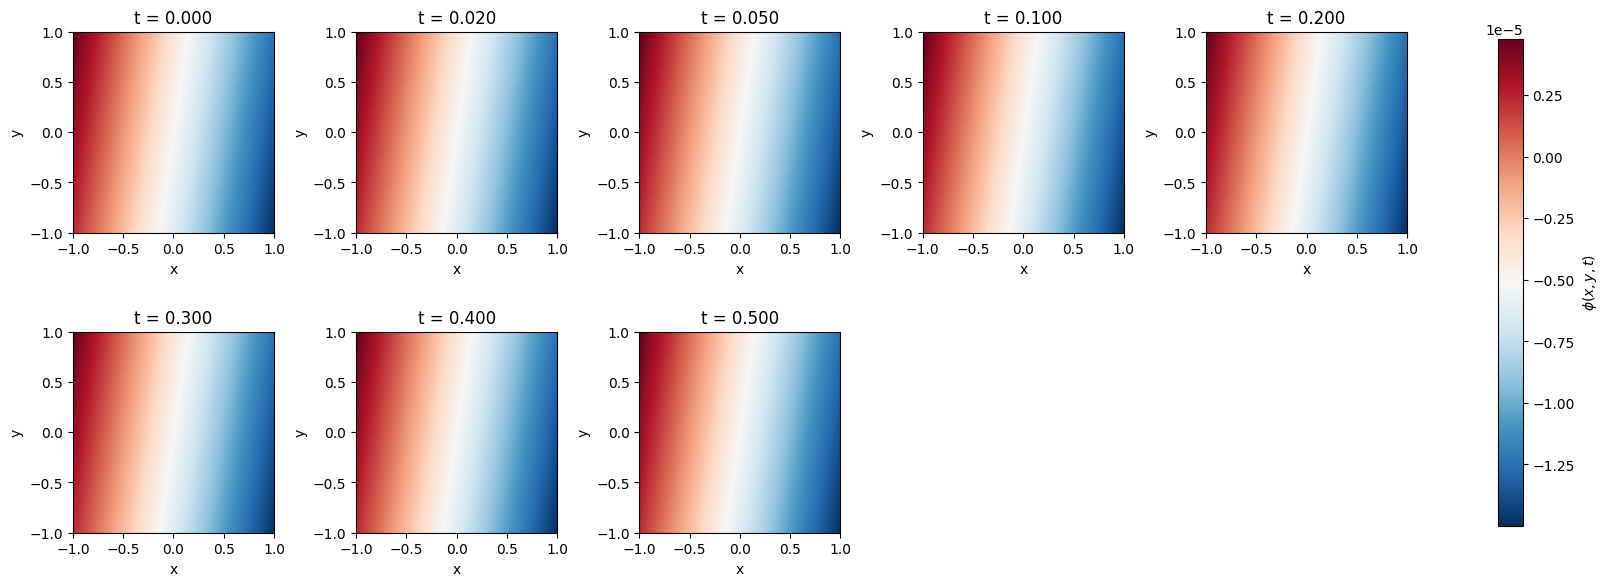

In [32]:
t_list = [0.0, 0.02, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50]
plot_wikipedia_style(net_phi, t_list, N=256, xlim=(-1,1), ylim=(-1,1),
                     vmin=None, vmax=None, device=device)


In [50]:
with torch.no_grad():
    phi_test = net_phi(x_f, y_f, t_f).cpu().numpy()
    print(phi_test.min(), phi_test.max(), phi_test.mean())


-7.150229e-07 3.3382094e-08 -3.40578e-07
